In [101]:
%matplotlib inline

from funcy import partial, pluck, walk_values
import matplotlib.pyplot as plt
import numpy as np
from nltk import word_tokenize
from nltk.corpus import stopwords
from sklearn.cross_validation import cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import LatentDirichletAllocation

from load import group_by, comments_grouped_by


In [102]:
comments_by_subreddit = comments_grouped_by('subreddit')



In [103]:
pool_every = 40

pool = lambda comments: ' '.join(pluck('body', comments))

def pool_n(n, comments):
    """Pool every n comments"""
    pools = []
    for i in range( (len(comments) / n) + 1):
        pools.append(pool(comments[i * n: max(len(comments), i * (n+1))]))
    return pools

subreddit_comments = {s: walk_values(partial(pool_n, pool_every), group_by(comments, 'author')) 
                          for s, comments in comments_by_subreddit.iteritems()
                     }

In [114]:
# take top n commenters in a subreddit subreddit
n_commenters = 30
subreddit = 'gameofthrones'
items = subreddit_comments[subreddit].items()
items = sorted (items, key = lambda (u, comments) : len(comments), reverse = True)[:15]
subreddit_comments[subreddit] = dict(items)



In [115]:

documents = []
labels = []
for user, user_comments in subreddit_comments[subreddit].items():
    documents += user_comments 
    labels += [user] * len(user_comments)

label_set = set(labels)
label_index = { label: i for i, label in enumerate(label_set) }
index_label  = { i: label for i, label in enumerate(label_set) }



In [116]:
vectorizer = CountVectorizer(min_df=2)
X = vectorizer.fit_transform(documents).toarray()
Y = np.array([label_index[l] for l in labels])



In [117]:
classifier = DecisionTreeClassifier()
# classifier.fit(X.toarray(), Y)
np.random.shuffle(X)
np.mean(cross_val_score(classifier, X, Y, cv=10))



0.055694444444444449

In [118]:
scores = {}
for topics in range(5, 55, 5):
    lda = LatentDirichletAllocation(n_topics=topics)
    X_new = lda.fit_transform(X)
    clf = DecisionTreeClassifier()
    scores[topics] = np.mean(cross_val_score(clf, X_new, Y, cv=10))
    
    

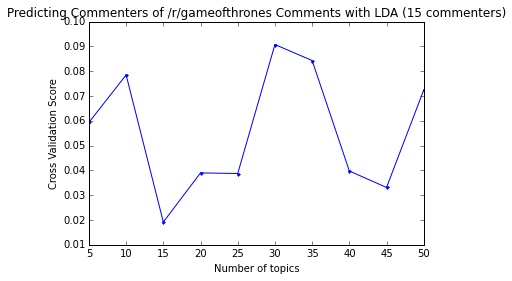

In [119]:
sorted_scores = sorted(scores.items(), key = lambda s:s[0])
plt.plot(pluck(0, sorted_scores), pluck(1, sorted_scores), '.-')
plt.title('Predicting Commenters of /r/gameofthrones Comments with LDA (%s commenters)' % len(set(Y))) 
plt.xlabel('Number of topics')
plt.ylabel('Cross Validation Score')
plt.show()



In [120]:

len(X)


139